In [1]:
import os
os.chdir('../')

In [2]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch

from src.DRL.qnetwork import QNetwork
from src.XAI.concept import Concept

In [3]:
model_path = QNetwork.find_newest_model()
model_path = "runs/20240321-223500_task_0/model_5000000.pt"
model = QNetwork(model_path=model_path)
model

Loaded model: 20240321-223500_task_0-5000000


QNetwork(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=5, bias=True)
  )
)

In [4]:
layer = model.network[0]
# Swap kernel width/height to plot canonically
weights = layer.weight.data.clone().permute(0, 1, 3, 2)

In [5]:
# Normalize weights to be between 0 and 1
weights_normalized = (weights - weights.min()) / (weights.max() - weights.min())

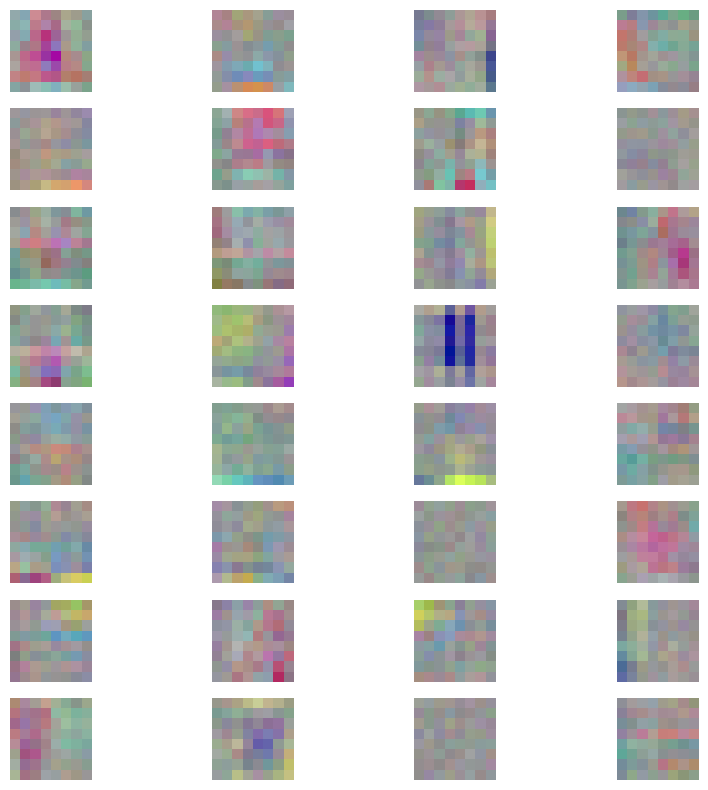

In [6]:
fig, axes = plt.subplots(8, 4, figsize=(10, 10))
for i in range(32):
    ax = axes[i // 4, i % 4]
    ax.imshow(weights_normalized[i].permute(1, 2, 0).cpu().numpy())
    ax.axis('off')
plt.show()

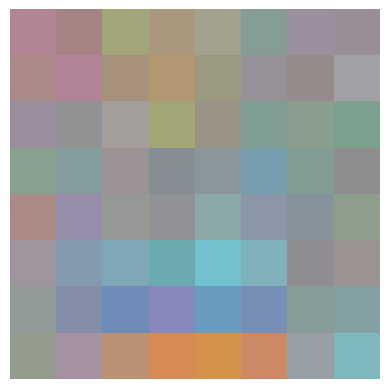

In [26]:
# lets take a closer look at a single kernel
kernel_index = 1
kernel = weights_normalized[kernel_index]
plt.imshow(kernel.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

In [27]:
env_steps = Concept.load_concept_data()
samples = 1000

observations = [step.observation for step in random.sample(env_steps, samples)]
observations = np.array(observations)
observations = torch.from_numpy(observations).float()
observations.shape

torch.Size([1000, 84, 84, 3])

In [37]:
# Lets pass examples through the first conv layer
outputs, all_activations = model(observations, return_acts=True)
activations = all_activations[0]
activations_flattened = activations.reshape(samples, -1).abs()
print(activations_flattened.shape)
# Take the max in the non-batch dimension, resulting in samples values
activations_scalar = activations_flattened.max(dim=1)[0]
#activations_scalar = activations_flattened.sum(dim=1)

# Sort the activations
sorted_activations, sorted_indices = activations_scalar.sort(descending=True)

torch.Size([1000, 12800])


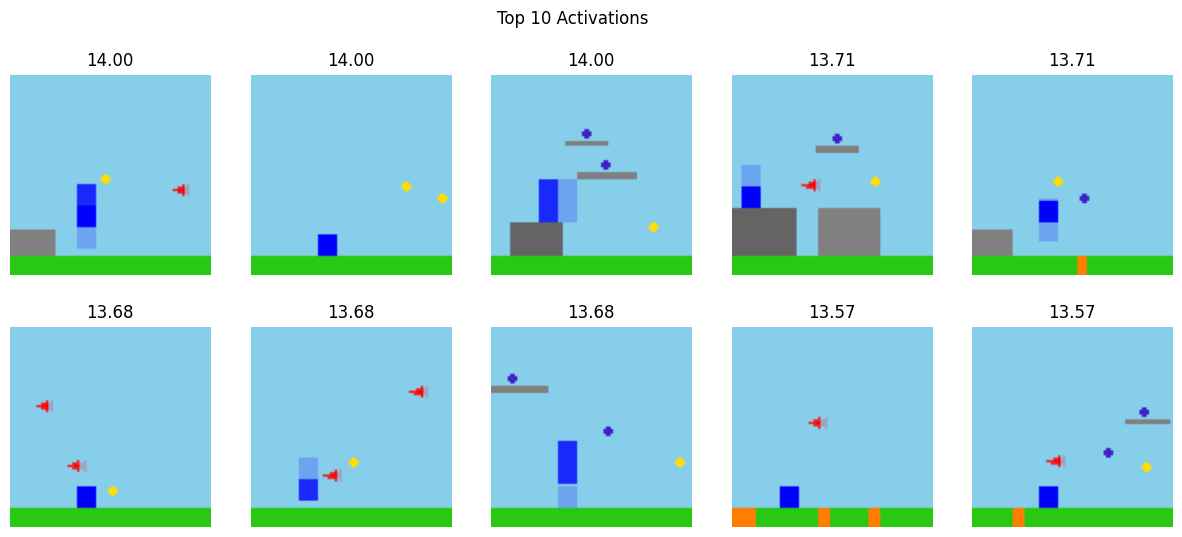

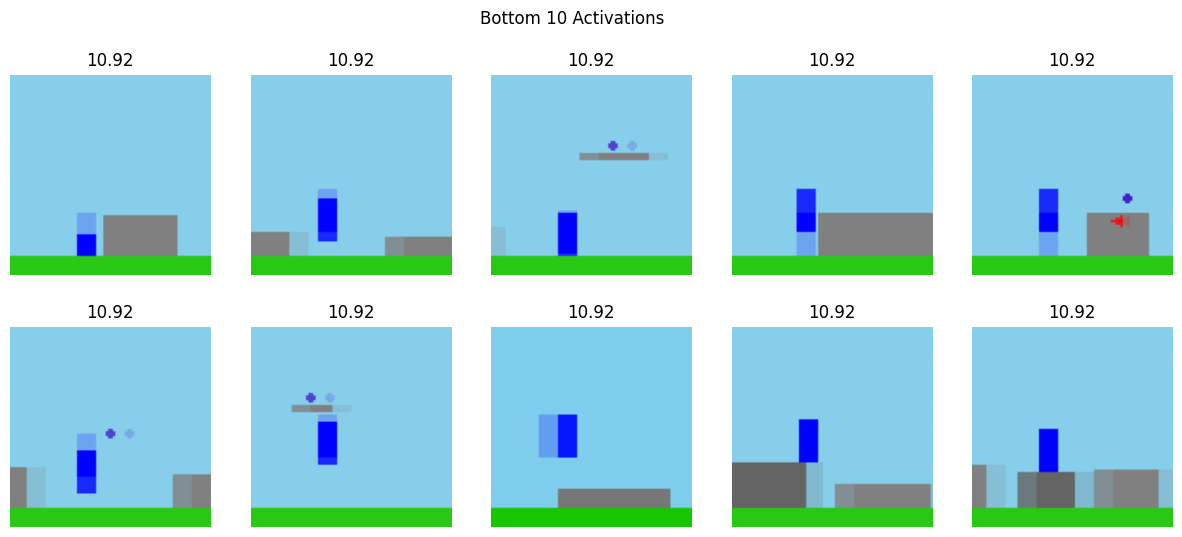

In [38]:
# Select top 10 and bottom 10 indices
top_10_indices = sorted_indices[:10]
bottom_10_indices = sorted_indices[-10:]

# Function to plot a set of observations
def plot_observations(indices, title):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(title)
    for i, idx in enumerate(indices):
        ax = axes[i // 5, i % 5]
        data = observations[idx].cpu().numpy()
        data = (data - data.min()) / (data.max() - data.min())
        ax.imshow(data)
        ax.axis('off')
        ax.set_title(f"{activations_scalar[idx]:.2f}")
    plt.show()

# Plot top 10 activations
plot_observations(top_10_indices, 'Top 10 Activations')

# Plot bottom 10 activations
plot_observations(bottom_10_indices, 'Bottom 10 Activations')

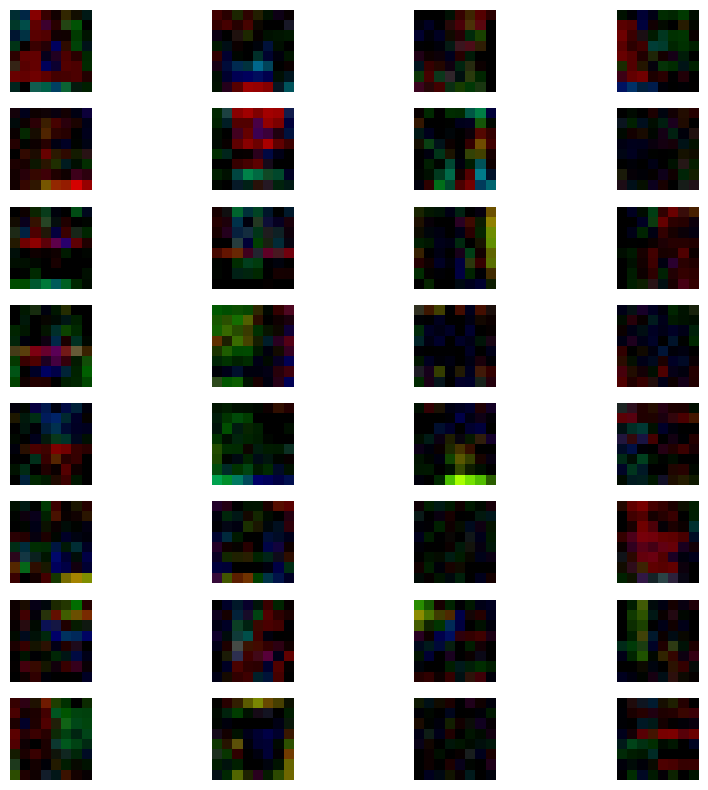

In [40]:
# Only grab the positive weights and set the rest to 0
weights_positive = weights > 0
weights_positive = weights * weights_positive
weights_positive = weights_positive / weights_positive.max()

# Plot the positive weights
fig, axes = plt.subplots(8, 4, figsize=(10, 10))
for i in range(32):
    ax = axes[i // 4, i % 4]
    ax.imshow(weights_positive[i].permute(1, 2, 0).cpu().numpy())
    ax.axis('off')
plt.show()


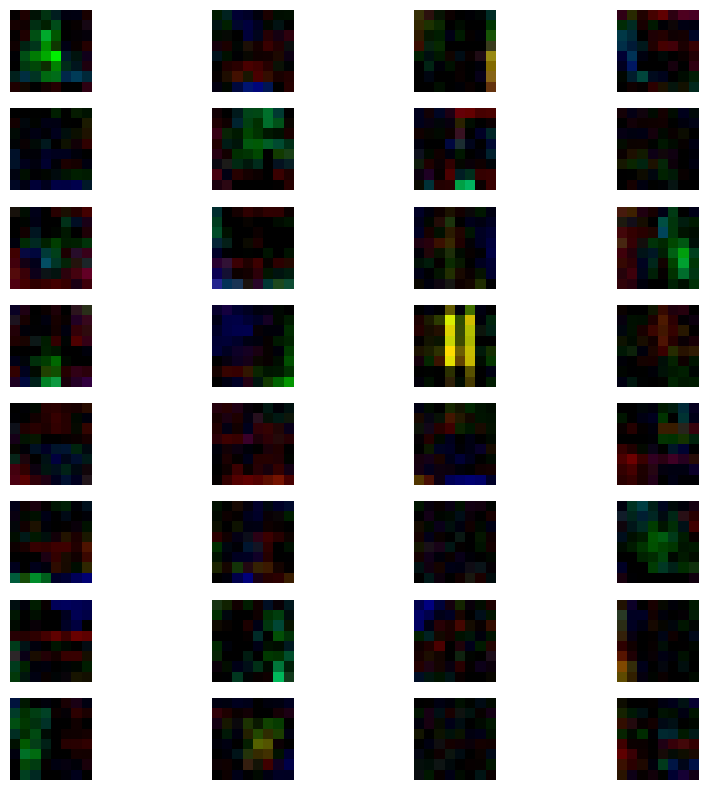

In [41]:
negative_weights = weights < 0
negative_weights = torch.abs(weights * negative_weights)
negative_weights = negative_weights / negative_weights.max()

# Plot the negative weights
fig, axes = plt.subplots(8, 4, figsize=(10, 10))
for i in range(32):
    ax = axes[i // 4, i % 4]
    ax.imshow(negative_weights[i].permute(1, 2, 0).cpu().numpy())
    ax.axis('off')
plt.show()

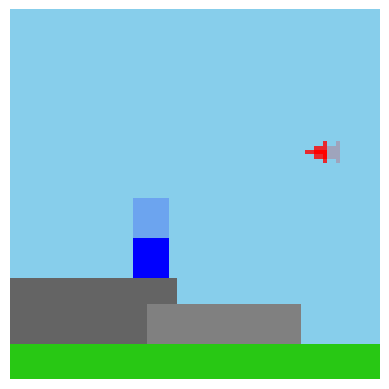

In [107]:
activations1 = all_activations[1]
example_idx = 30
# Show example img
img_data = observations[example_idx].cpu().numpy()
img_data = (img_data - img_data.min()) / (img_data.max() - img_data.min())
plt.imshow(img_data)
plt.axis('off')
plt.show()

/tmp/ipykernel_17334/3706061270.py:5: RuntimeWarning: invalid value encountered in divide
  data = (data - data.min()) / (data.max() - data.min())


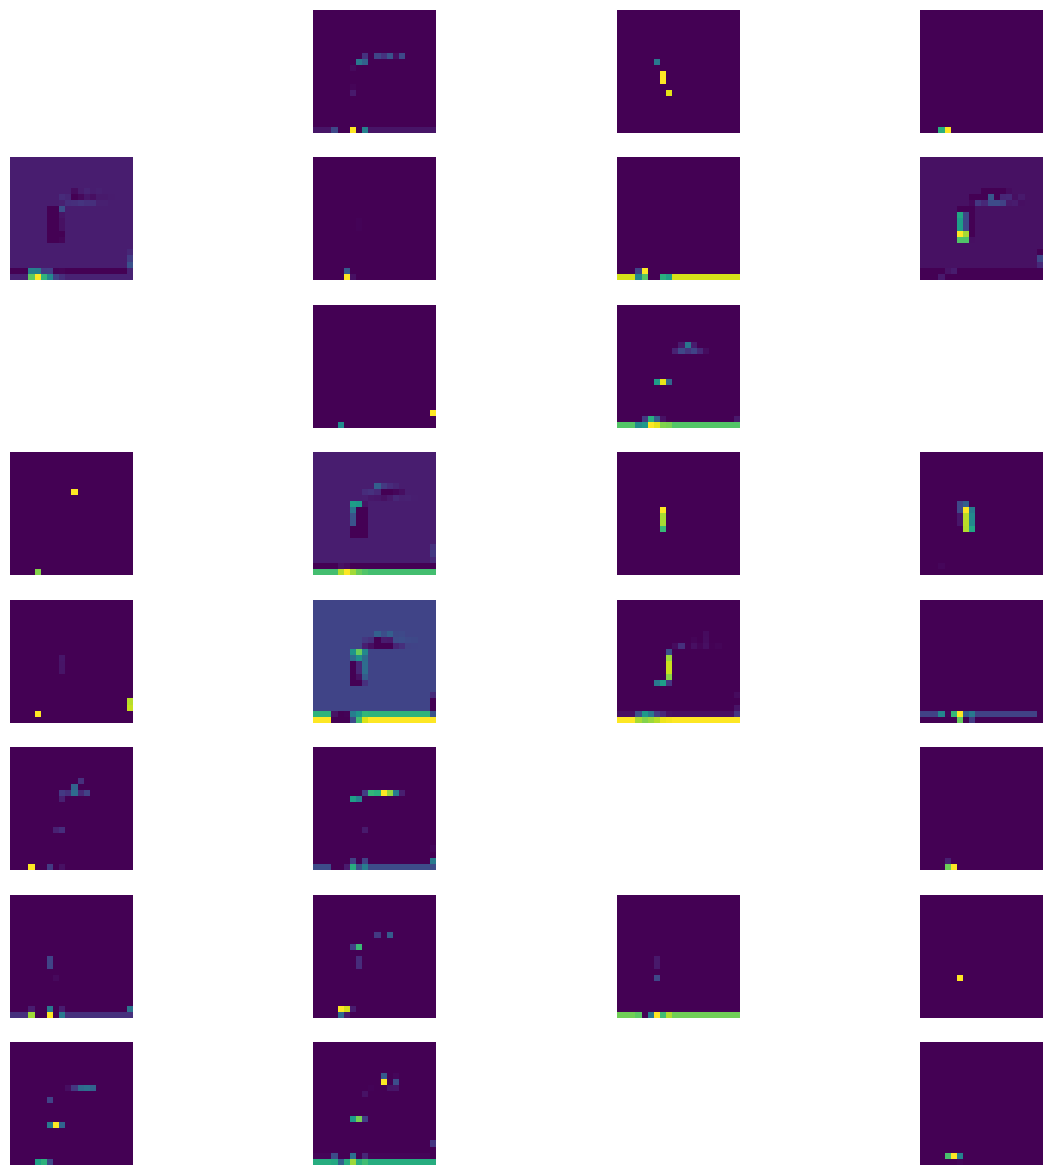

In [95]:
fig, axes = plt.subplots(8, 4, figsize=(15, 15))
for kernel_idx in range(32):
    ax = axes[kernel_idx // 4, kernel_idx % 4]
    data = activations1[example_idx, kernel_idx].cpu().numpy()
    data = (data - data.min()) / (data.max() - data.min())
    ax.imshow(data, cmap='viridis')
    ax.axis('off')
plt.show()

/tmp/ipykernel_17334/3061947720.py:6: RuntimeWarning: invalid value encountered in divide
  data = (data - data.min()) / (data.max() - data.min())


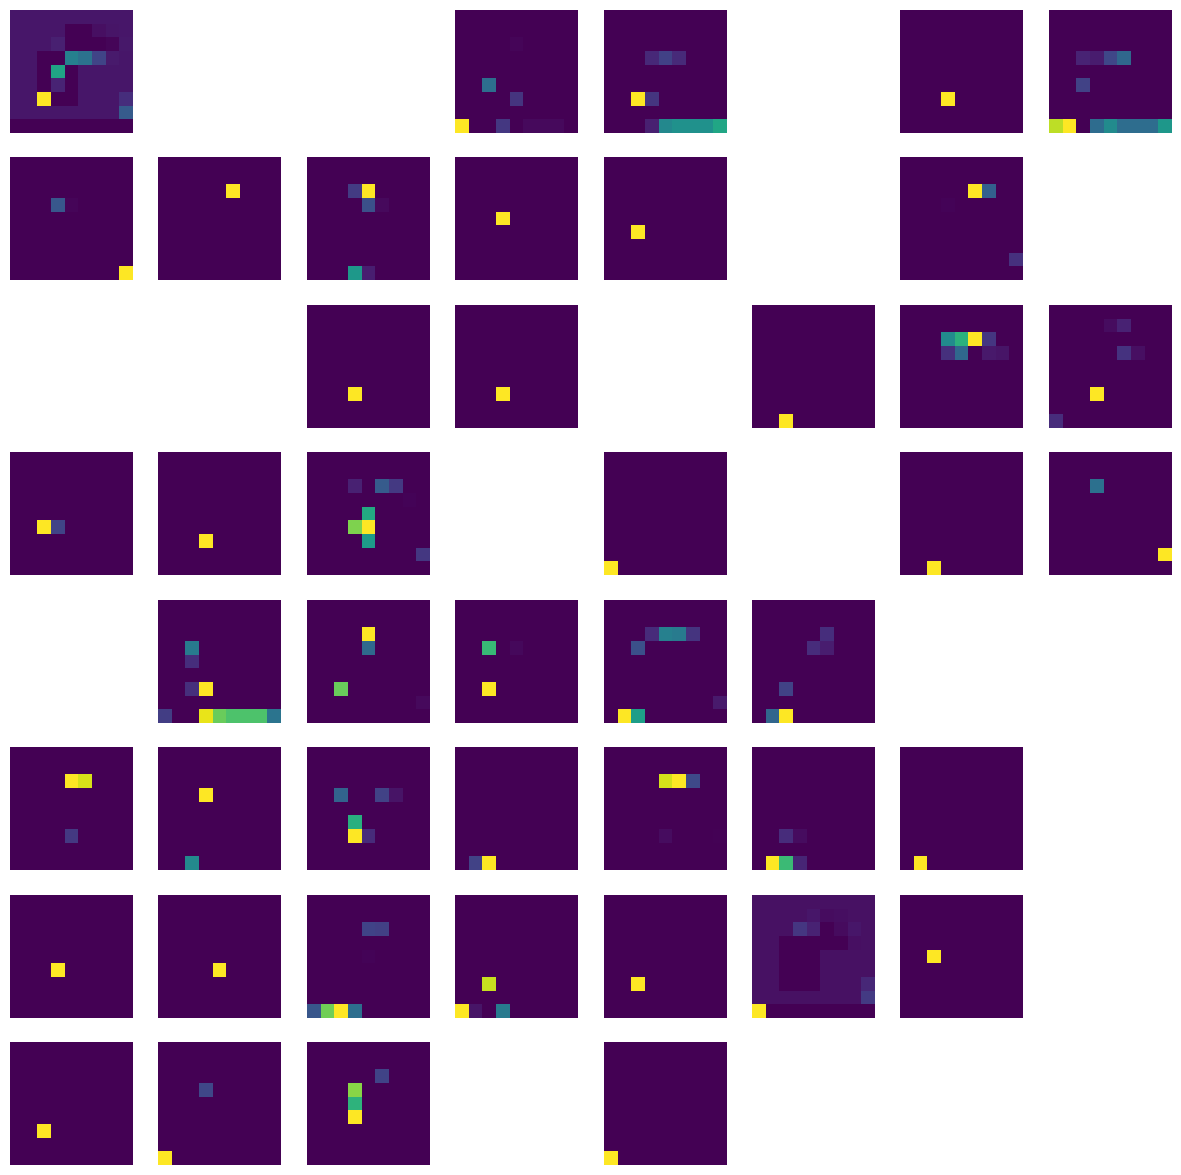

In [96]:
activations3 = all_activations[3]
fig, axes = plt.subplots(8, 8, figsize=(15, 15))
for kernel_idx in range(activations3.shape[1]):
    ax = axes[kernel_idx // 8, kernel_idx % 8]
    data = activations3[example_idx, kernel_idx].cpu().numpy()
    data = (data - data.min()) / (data.max() - data.min())
    ax.imshow(data, cmap='viridis')
    ax.axis('off')
plt.show()